### the code presented in this notebook performs classification task of predicting Russell 2000 movement as 'up', 'down', or 'range-bound' ...  `KNeighborsClassifier()` | `LogisticRegression()` | `DecisionTreeClassifier()` | and `SVC()` models will be avaluated and selected based on accuracy

### Findings | Actionable Insights | Recommendations:

<font color="blue">Models Comparison: Based on the trade-offs between accuracy, precision, recall, and computational efficiency, we can choose the following classifiers (please review the summary dataframe at the very bottom of the notebook)</font>:
- out of four AI models used for the classification of index' move 'up', 'down', or 'range-bound' (KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, and Support Vector Machines) we recommend using the LogisticRegression model for predicting Russell 2000 directional movement

<font color="blue">Observations related to data understanding, pre-processing, and modeling (dive into code and code comments below)</font>:
- recommendation(s) will go here ...
  
<font color="blue">Recommendations for specific options trade strategy</font>:
- an options trader should establish a long straddle position on the Russell 2000 index on the eve of the FOMC (Federal Open Market Committee) announcement, preferably 2-3 trading days in advance

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading dataset as a dataframe from local folder
russell_2000 = pd.read_csv('C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/russell_2000_frequency_B.csv')

In [3]:
# starting EDA (exploratory data analysis)
russell_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1095 non-null   object 
 1   Open              1095 non-null   float64
 2   High              1095 non-null   float64
 3   Low               1095 non-null   float64
 4   Close             1095 non-null   float64
 5   Adj Close         1095 non-null   float64
 6   Range             1095 non-null   float64
 7   daily_delta       1095 non-null   float64
 8   percentage_delta  1095 non-null   float64
 9   Volume            1095 non-null   int64  
 10  Event             1095 non-null   int64  
 11  Category          1095 non-null   int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 102.8+ KB


In [4]:
# dropping the 'Adj close' column since it is identical to 'Close' column + renaming 'Close' for easier interpretation
russell_2000.drop('Adj Close', axis=1, inplace=True)
russell_2000.rename(columns={'Close': 'closing_price'}, inplace=True)

In [5]:
# running diagnostic for how russell_2000 dataframe looks like now
print(russell_2000.info())
print(type(russell_2000))
print(len(russell_2000))
print(russell_2000.shape)
print(russell_2000.dtypes) # this is covered by .info() function, but running it to double confirm expected output
russell_2000.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1095 non-null   object 
 1   Open              1095 non-null   float64
 2   High              1095 non-null   float64
 3   Low               1095 non-null   float64
 4   closing_price     1095 non-null   float64
 5   Range             1095 non-null   float64
 6   daily_delta       1095 non-null   float64
 7   percentage_delta  1095 non-null   float64
 8   Volume            1095 non-null   int64  
 9   Event             1095 non-null   int64  
 10  Category          1095 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 94.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
1095
(1095, 11)
Date                 object
Open                float64
High                float64
Low                 float64
closing_price       float64
Range               

,Date,Open,High,Low,closing_price,Range,daily_delta,percentage_delta,Volume,Event,Category
198,10/8/2020,1615.27002,1630.329956,1615.27002,1628.550049,15.059936,17.51001,1.086876,3867640000,0,0


In [6]:
# dropping 'Date' based on domain-specific knowledge
russell_2000.drop('Date', axis=1, inplace=True)

In [7]:
# confirming that the 'Date' feature has been dropped ... yep, it's gone
russell_2000.sample()

,Open,High,Low,closing_price,Range,daily_delta,percentage_delta,Volume,Event,Category
795,1868.959961,1896.199951,1867.48999,1890.77002,28.709961,23.430054,1.254729,3945210000,0,0


In [8]:
# examining our target 'Category' column which contains data for Russell's 'range-bound', 'up', and 'down' movement
# observation(s) for options trader: in majority of cases (81%) data is 'range-bound' and that suggests selling a straddle or strangle
print(russell_2000.Category.value_counts())
print(russell_2000.Category.value_counts(normalize=True))

Category
0    884
1    115
2     96
Name: count, dtype: int64
Category
0    0.807306
1    0.105023
2    0.087671
Name: proportion, dtype: float64


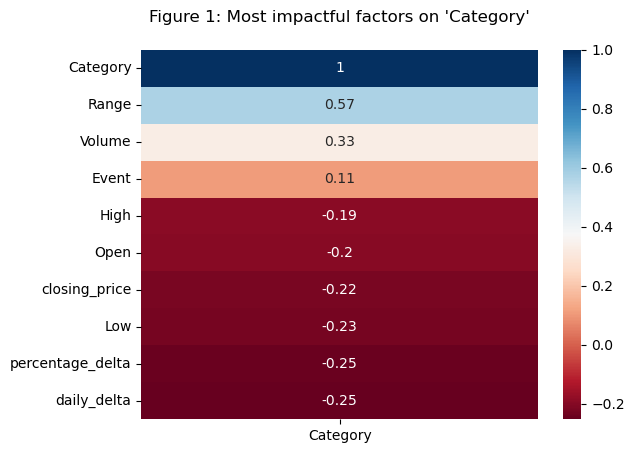

In [9]:
# let's discover which featues has a biggest impact on our target variable 'Category'
# observation(s) for options trader: 'Range', 'Volume', and 'Event' have the biggest impact on our target variable 'Category'
sns.heatmap(russell_2000.corr()[['Category']].sort_values(by = 'Category', ascending = False), annot = True, cmap="RdBu")
plt.title("Figure 1: Most impactful factors on 'Category'", pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v11.png")

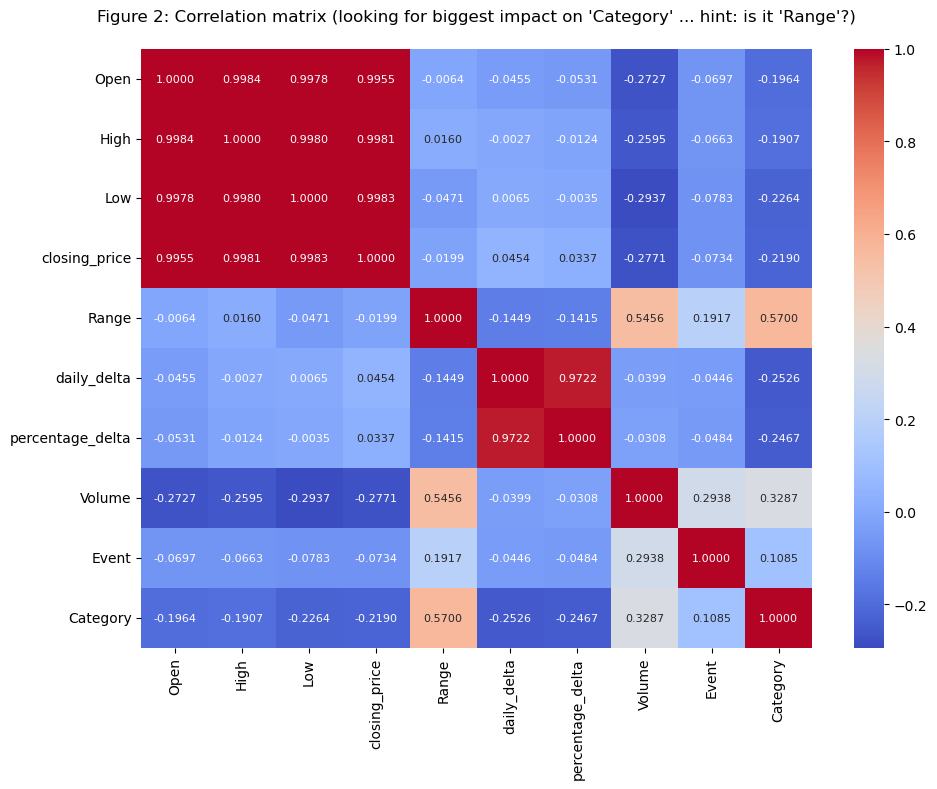

In [10]:
# investigating further which featues has a biggest impact on 'Category' (target variable)
# observation(s) for options trader: yep, 'Range', 'Volume', and 'Event' have the biggest impact on our dependent variable 'Category'
corr_matrix = russell_2000[russell_2000.columns.tolist()].corr()
# setting up the matplotlib figure
plt.figure(figsize=(10, 8))
# plotting the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", annot_kws={"size": 8})
plt.title("Figure 2: Correlation matrix (looking for biggest impact on 'Category' ... hint: is it 'Range'?)", pad=20)
plt.tight_layout()
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v12.png")
plt.show()

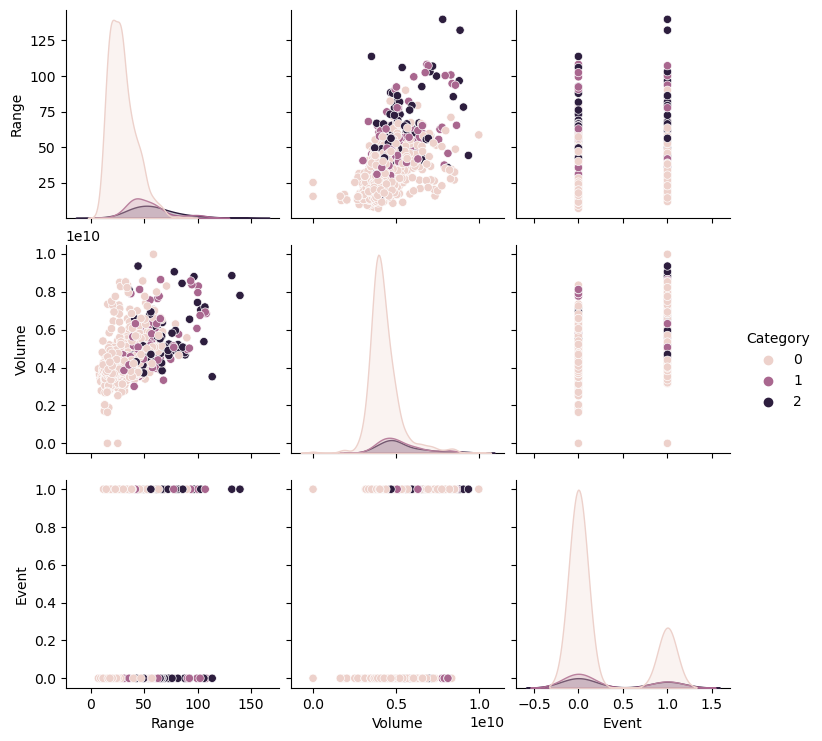

In [11]:
# reviewing distribution of data: building pairplots based on three most impactful features
sns.pairplot(russell_2000[['Range', 'Volume', 'Event', 'Category']], hue = 'Category')
# plt.title("Figure 3: Pairplots of the top three impactful factors", pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v13.png")

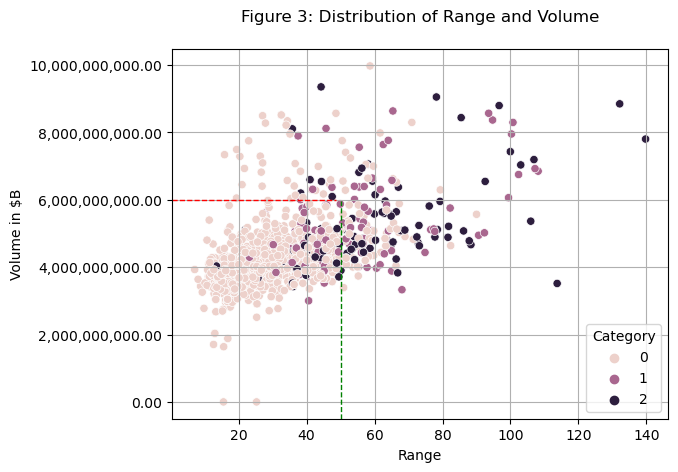

In [12]:
# reviewing the distribution of most impactful features i.e. 'Range' and 'Volume'
# observation(s) for options trader: move 'down' is much more volitile than the move 'up' or 'range-bound'
# observation(s) for options trader: moves 'up' and 'down' occur on the days with significant volume in trades above $6B - buy straddle
# observation(s) for options trader: likewise, 'range-bound' movements occur mostly below $6B volume - sell straddle
sns.scatterplot(data = russell_2000, x = 'Range', y='Volume', hue='Category')
plt.ylabel('Volume in $B')
plt.axhline(y=6000000000, xmax=0.33, color='r', linestyle='--', linewidth=1)
plt.axvline(x=50, ymax=0.59, color='g', linestyle='--', linewidth=1)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))
plt.grid(True)
plt.title("Figure 3: Distribution of Range and Volume", pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v14.png")

In [13]:
# splitting the data into training 80% and testing 20% sets
X_train, X_test, y_train, y_test = train_test_split(russell_2000.drop('Category', axis = 1), russell_2000['Category'], test_size=0.2, random_state=71)

In [14]:
# analyzing composition of categories of target variable to build correct labels for the confusion matrixes of classification models
# to translate: 168 values are 'range-bound' movement, 24 values are 'up' movement, and 27 values are 'down' movement
print(y_test.unique())
print(y_test.value_counts())

[0 2 1]
Category
0    168
2     27
1     24
Name: count, dtype: int64


In [15]:
# confirming expected output after data split
print(X_train.sample(), type(X_train))
print(y_train.sample(), type(y_train))

print(X_train.shape, y_train.shape)
print(' should be 80% of 1,095 - and it is! \n' )
print(X_test.shape, y_test.shape)
print(' should be 20% of 1,095 - and it is! \n' )

            Open         High          Low  closing_price      Range  \
433  2288.030029  2309.969971  2288.030029     2304.02002  21.939942   

     daily_delta  percentage_delta      Volume  Event  
433    16.959961          0.741562  3735990000      0   <class 'pandas.core.frame.DataFrame'>
765    0
Name: Category, dtype: int64 <class 'pandas.core.series.Series'>
(876, 9) (876,)
 should be 80% of 1,095 - and it is! 

(219, 9) (219,)
 should be 20% of 1,095 - and it is! 



In [16]:
# conducting GridSearchCV() to obtain best parameters for KNeighborsClassifier() ... runs fairly quickly
knn_pipe = Pipeline([('scale', StandardScaler()), ('model', KNeighborsClassifier())])
params = {'model__n_neighbors': list(range(1, 22, 2)), 'model__weights': ['uniform', 'distance'], 'model__p': [1, 2]}
knn_grid = GridSearchCV(knn_pipe, param_grid=params).fit(X_train, y_train)
knn_grid.best_params_

{'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}

In [17]:
# performing classification of Russell 2000 'up', 'down', 'range-bound' movement using KNeighborsClassifier()
# observation: accuracy score = to recall score
start_time_knn = time.time()

knn = Pipeline([('scale', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=5, weights='distance', p=1))]).fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average='weighted')
knn_recall = recall_score(y_test, y_pred, average='weighted')

end_time_knn = time.time()
time_taken_knn = end_time_knn - start_time_knn

print("Time taken:", time_taken_knn, "seconds")
print("KNeighborsClassifier accuracy score:", knn_accuracy)
print("KNeighborsClassifier precision score:", knn_precision)
print("KNeighborsClassifier recall score:", knn_recall)

Time taken: 0.022804975509643555 seconds
KNeighborsClassifier accuracy score: 0.9452054794520548
KNeighborsClassifier precision score: 0.9478287637772618
KNeighborsClassifier recall score: 0.9452054794520548


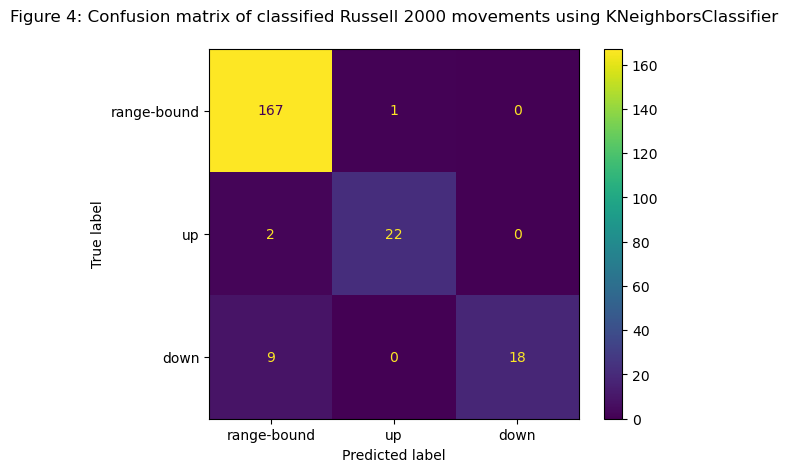

In [18]:
knn_confusion_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_mat, display_labels=['range-bound', 'up', 'down'])
disp.plot()
plt.title("Figure 4: Confusion matrix of classified Russell 2000 movements using KNeighborsClassifier", pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v15.png")
plt.show()

In [19]:
# conducting GridSearchCV() to obtain best parameters for LogisticRegression() ... runs fairly quickly (few min)
log_pipe = Pipeline([('logmodel', LogisticRegression())])
logparams = {'logmodel__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logmodel__penalty': ['l1', 'l2'], 'logmodel__solver': ['liblinear', 'saga']}
log_grid = GridSearchCV(log_pipe, param_grid=logparams).fit(X_train, y_train)
log_grid.best_params_

{'logmodel__C': 100,
 'logmodel__penalty': 'l1',
 'logmodel__solver': 'liblinear'}

In [20]:
# performing classification of Russell 2000 'up', 'down', 'range-bound' movement using LogisticRegression()
start_time_logistic = time.time()

logreg = LogisticRegression(C=100, solver='liblinear', penalty='l1').fit(X_train, y_train)
preds = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, preds)
logreg_precision = precision_score(y_test, preds, average='weighted')
logreg_recall = recall_score(y_test, preds, average='weighted')

end_time_logistic = time.time()
time_taken_logistic = end_time_logistic - start_time_logistic

print("Time taken:", time_taken_logistic, "seconds")
print("LogisticRegression accuracy score:", logreg_accuracy)
print("LogisticRegression precision score:", logreg_precision)
print("LogisticRegression recall score:", logreg_recall)

Time taken: 0.3759472370147705 seconds
LogisticRegression accuracy score: 0.9817351598173516
LogisticRegression precision score: 0.9821599235425293
LogisticRegression recall score: 0.9817351598173516


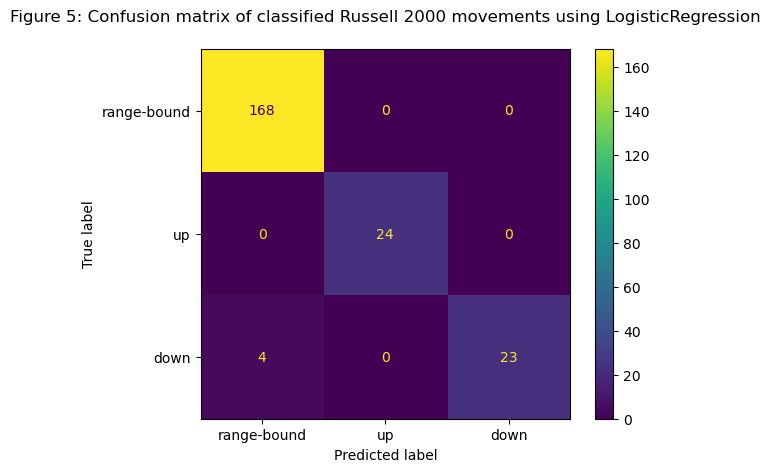

In [21]:
logreg_confusion_mat = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=logreg_confusion_mat, display_labels=['range-bound', 'up', 'down'])
disp.plot()
plt.title("Figure 5: Confusion matrix of classified Russell 2000 movements using LogisticRegression", pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v16.png")
plt.show()

In [22]:
# conducting GridSearchCV() to obtain best parameters for DecisionTreeClassifier() ... runs fairly quickly (few min)
tree_pipe = Pipeline([('treemodel', DecisionTreeClassifier())])
treeparams = {'treemodel__criterion': ['gini', 'entropy'], 'treemodel__max_depth': [3, 5, 10, 15, 20], 'treemodel__min_samples_split': [0.1, 0.2, 0.05], 'treemodel__min_samples_leaf': [1, 2, 4]}
tree_grid = GridSearchCV(tree_pipe, param_grid=treeparams).fit(X_train, y_train)
tree_grid.best_params_

{'treemodel__criterion': 'gini',
 'treemodel__max_depth': 3,
 'treemodel__min_samples_leaf': 1,
 'treemodel__min_samples_split': 0.1}

In [23]:
# performing classification of Russell 2000 'up', 'down', 'range-bound' movement using DecisionTreeClassifier()
# observation: all the scores are 1.0 ... does that mean that model is overfitted?
start_time_tree = time.time()

tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=0.1).fit(X_train, y_train)
preds_tree = tree.predict(X_test)
tree_accuracy = accuracy_score(y_test, preds_tree)
tree_precision = precision_score(y_test, preds_tree, average='weighted')
tree_recall = recall_score(y_test, preds_tree, average='weighted')

end_time_tree = time.time()
time_taken_tree = end_time_tree - start_time_tree

print("Time taken:", time_taken_tree, "seconds")
print("DecisionTreeClassifier accuracy score:", tree_accuracy)
print("DecisionTreeClassifier precision score:", tree_precision)
print("DecisionTreeClassifier recall score:", tree_recall)

Time taken: 0.020555734634399414 seconds
DecisionTreeClassifier accuracy score: 1.0
DecisionTreeClassifier precision score: 1.0
DecisionTreeClassifier recall score: 1.0


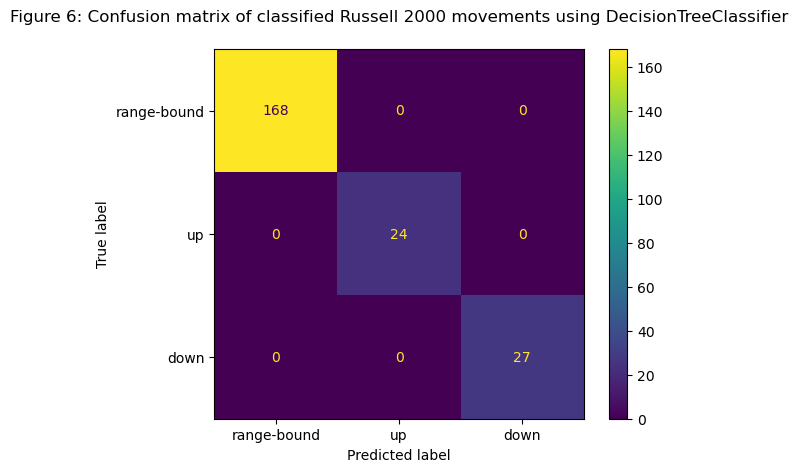

In [24]:
tree_confusion_mat = confusion_matrix(y_test, preds_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=tree_confusion_mat, display_labels=['range-bound', 'up', 'down'])
disp.plot()
plt.title("Figure 6: Confusion matrix of classified Russell 2000 movements using DecisionTreeClassifier", pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v17.png")
plt.show()

In [25]:
# conducting GridSearchCV() to obtain best parameters for SVC() ... runs fairly quickly
svc_pipe = Pipeline([('scale', StandardScaler()), ('svcmodel', SVC())])
svcparams = {'svcmodel__C': [0.1, 1, 10, 100], 'svcmodel__gamma': [0.1, 1.0, 10.0, 100.0], 'svcmodel__kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
svc_grid = GridSearchCV(svc_pipe, param_grid=svcparams).fit(X_train, y_train)
svc_grid.best_params_

{'svcmodel__C': 100, 'svcmodel__gamma': 0.1, 'svcmodel__kernel': 'linear'}

In [28]:
# performing classification of Russell 2000 'up', 'down', 'range-bound' movement using SVC()
# observation: despite suggested by grid search kernel being 'linear', we're using 'rbf' ... 'linear' stalls model's training
# observation: after scalling the data 'rbf' and 'linear' produce accuracy of 1.0 ... does that mean that model is overfitted?
start_time_svc = time.time()

vector = SVC(C=100, kernel='rbf', gamma=0.1).fit(X_train, y_train)
# vector = Pipeline([('scale', StandardScaler()), ('svcmodel', SVC(C=100, kernel='rbf', gamma=0.1))]).fit(X_train, y_train)
# vector = Pipeline([('scale', StandardScaler()), ('svcmodel', SVC(C=100, kernel='linear', gamma=0.1))]).fit(X_train, y_train)
preds_vector = vector.predict(X_test)
svc_accuracy = accuracy_score(y_test, preds_vector)
svc_precision = precision_score(y_test, preds_vector, average='weighted', zero_division=1)
svc_recall = recall_score(y_test, preds_vector, average='weighted')

end_time_svc = time.time()
time_taken_svc = end_time_svc - start_time_svc

print("Time taken:", time_taken_svc, "seconds")
print("Support Vector Classifier accuracy score:", svc_accuracy)
print("Support Vector Classifier precision score:", svc_precision)
print("Support Vector Classifier recall score:", svc_recall)

Time taken: 0.1611618995666504 seconds
Support Vector Classifier accuracy score: 0.776255707762557
Support Vector Classifier precision score: 0.8267786124613345
Support Vector Classifier recall score: 0.776255707762557


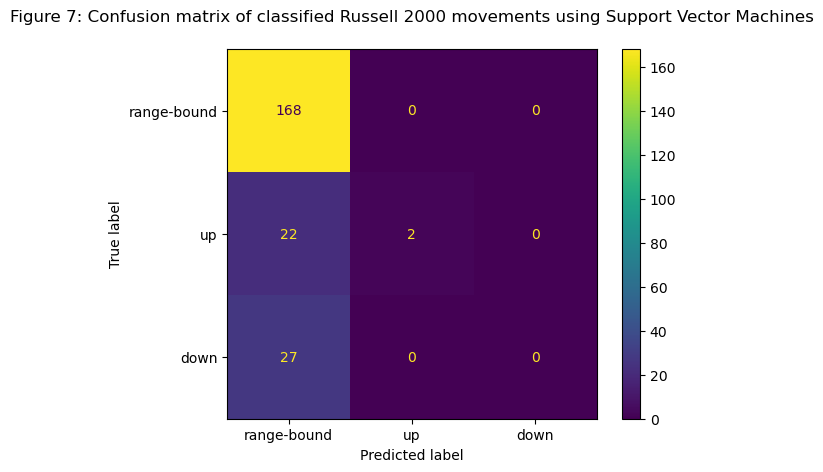

In [29]:
svc_confusion_mat = confusion_matrix(y_test, preds_vector)
disp = ConfusionMatrixDisplay(confusion_matrix=svc_confusion_mat, display_labels=['range-bound', 'up', 'down'])
disp.plot()
plt.title("Figure 7: Confusion matrix of classified Russell 2000 movements using Support Vector Machines", pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v18.png")
plt.show()

In [30]:
# setting dataframe display opions so that we can see the entire summary at once
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [32]:
# setting up summary of model comparison dataframe and displaying it
res_dict = {'model': ['KNeighborsClassifier()', 'LogisticRegression()', 'DecisionTreeClassifier()', 'SVC()'],
            'time in seconds': [time_taken_knn, time_taken_logistic, time_taken_tree, time_taken_svc],
            'accuracy score': [knn_accuracy, logreg_accuracy, tree_accuracy, svc_accuracy],
            'precision score': [knn_precision, logreg_precision, tree_precision, svc_precision],
            'recall score': [knn_recall, logreg_recall, tree_recall, svc_recall],
            'best parameters':["{'n_neighbors': 5, 'weights': 'distance', 'p': 1}", "{'C': 100, 'solver': 'liblinear', 'penalty': 'l1'}", "{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 0.1}", "{'C': 100, 'kernel': 'rbf', 'gamma': 0.1}"]}
results_df = pd.DataFrame(res_dict).set_index('model')
results_df

,time in seconds,accuracy score,precision score,recall score,best parameters
model,,,,,
KNeighborsClassifier(),0.022805,0.945205,0.947829,0.945205,"{'n_neighbors': 5, 'weights': 'distance', 'p': 1}"
LogisticRegression(),0.375947,0.981735,0.982160,0.981735,"{'C': 100, 'solver': 'liblinear', 'penalty': 'l1'}"
DecisionTreeClassifier(),0.020556,1.000000,1.000000,1.000000,"{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 0.1}"
SVC(),0.161162,0.776256,0.826779,0.776256,"{'C': 100, 'kernel': 'rbf', 'gamma': 0.1}"
